In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('monthly.csv', index_col='Date',parse_dates=True)
df.index.asfreq = 'MS'

In [3]:
df.head()

,Consumption
Date,
2008-01-01,589.0
2008-02-01,561.0
2008-03-01,640.0
2008-04-01,656.0
2008-05-01,727.0


<AxesSubplot:xlabel='Date'>

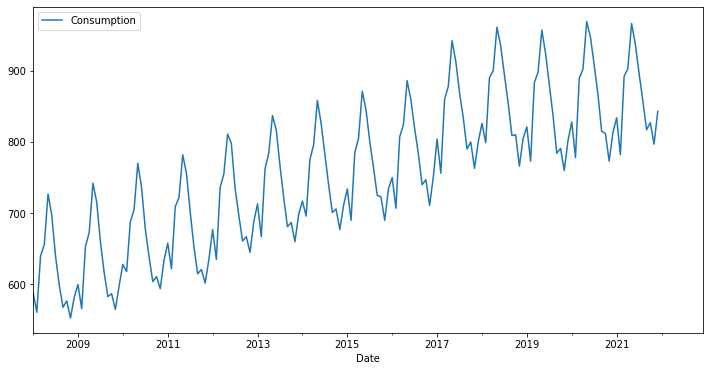

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
results = seasonal_decompose(df['Consumption'])
results.plot()

ValueError: This function does not handle missing values

In [7]:
len(df)

180

In [8]:
train = df.iloc[:156]
test = df.iloc[156:]

In [9]:
test

,Consumption
Date,
2021-01-01,834.0
2021-02-01,782.0
2021-03-01,892.0
2021-04-01,903.0
2021-05-01,966.0
2021-06-01,937.0
2021-07-01,896.0
2021-08-01,858.0
2021-09-01,817.0


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
df.head(), df.tail()

(            Consumption
 Date                   
 2008-01-01        589.0
 2008-02-01        561.0
 2008-03-01        640.0
 2008-04-01        656.0
 2008-05-01        727.0,
             Consumption
 Date                   
 2022-08-01          NaN
 2022-09-01          NaN
 2022-10-01          NaN
 2022-11-01          NaN
 2022-12-01          NaN)

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
#define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length =n_input,batch_size=1)

In [16]:
X,y = generator[1]
print(f'Given the Array:  \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array:  
[0.01923077 0.20913462 0.24759615 0.41826923 0.34615385 0.20913462
 0.11057692 0.03605769 0.05769231 0.         0.06971154 0.11298077]
Predict this y: 
 [[0.03125]]


In [17]:
X.shape

(1, 12, 1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
model = Sequential()
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


TypeError: 'History' object is not subscriptable

In [21]:
generator_cv = TimeseriesGenerator(scaled_test,scaled_test,length =n_input,batch_size=1)

In [21]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 3ms/step - loss: 0.0396
Epoch 2/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0221
Epoch 3/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0159
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0086
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 6/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 7/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 9/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 10/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 11/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 12/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 13/50
144/144 [====

In [23]:
model.save('monthly_model.h5')

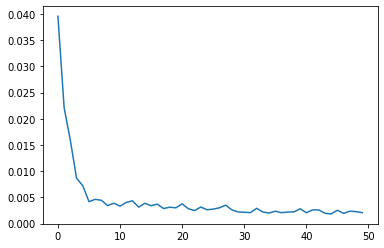

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-12:]



In [ ]:
last_train_batch = last_train_batch.reshape((1,n_input,n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.6216918]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]],axis=1)
    

In [ ]:
test_predictions

[array([0.6216918], dtype=float32),
 array([0.5938695], dtype=float32),
 array([0.7758399], dtype=float32),
 array([0.85916764], dtype=float32),
 array([0.97144425], dtype=float32),
 array([0.9422105], dtype=float32),
 array([0.86427003], dtype=float32),
 array([0.7674486], dtype=float32),
 array([0.66529804], dtype=float32),
 array([0.621454], dtype=float32),
 array([0.56309295], dtype=float32),
 array([0.6120897], dtype=float32)]

In [ ]:
test

,Consumption
Date,
2022-01-01,834
2022-02-01,782
2022-03-01,892
2022-04-01,903
2022-05-01,966
2022-06-01,937
2022-07-01,896
2022-08-01,858
2022-09-01,817


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions


C:\Users\ADMIN\AppData\Local\Temp/ipykernel_13800/425898741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

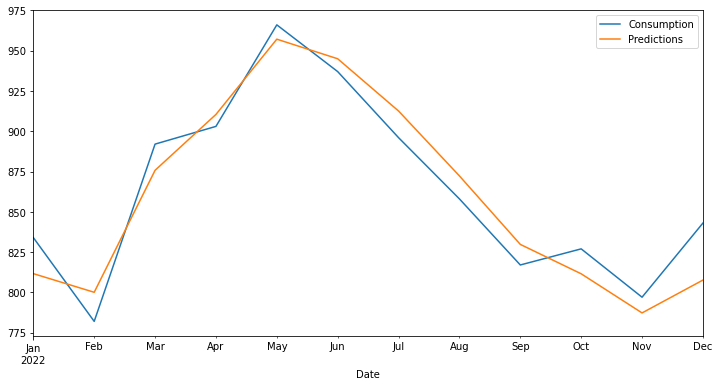

In [ ]:
test.plot(figsize=(12,6))

In [ ]:
test


,Consumption,Predictions
Date,,
2022-01-01,834,811.623798
2022-02-01,782,800.049715
2022-03-01,892,875.749409
2022-04-01,903,910.413736
2022-05-01,966,957.120808
2022-06-01,937,944.959566
2022-07-01,896,912.536333
2022-08-01,858,872.258619
2022-09-01,817,829.763987


In [ ]:
model.save('monthly_model.h5')